# DSCI Group 005 21 Project Report "Nature vs. Nurture: The Long Standing Debate in Sports Performance"

### Introduction:

Sports is an important activity that have multiple benefits for both our physical and mental health, but the public’s interest in it have been declining. Most children stop playing sports at the age of 13 and one of the reasons why is they lose interest and motivation when they don’t immediately excel in that particular sport (Miner, 2016). This causes them to believe that they lack “talent”, which a lot of people are claiming to be important in order to achieve success in any area. Talent is defined as natural skill or abilities but its exact properties are still largely unknown by experts. Since talent is something that is immeasurable, we aim to answer the question of what makes someone skilled at sports by observing players' rank and their total experience instead. 

We’ll be using the dataset “Player Stats for Top 500 Players” provided by Ultimate Tennis Statistics in our report. The dataset contains statistics for 499 players from all over the world including their birthdate, nationality, the number of seasons they played, their current and best rankings. In our data analysis, we’ll only be considering the variables seasons and current rank. Our goal is to see whether the number of seasons someone have played in their career can predict their current ranking. We'll be using both linear regression and KNN regression prediction methods and then see if any of them will produce an accurate prediction model.

### Methods & Results:

In order to solve the predictive problem, we use both linear regression and K-nearest neighbors (KNN) regression. 
We start by loading packages, setting the seed, loading data, wrangling data and cleaning them.

In [1]:
library(tidyverse)
library(tidymodels)

# set seed
set.seed(100)

# read and tidy data
player_stats <- read_csv("player_stats.csv")
colnames(player_stats)[colnames(player_stats) == "Current Rank"] <- "Current_Rank"
player_stats <- player_stats |>
    separate(col = Current_Rank, into = c("current_rank", "other_rank"), sep = " ", convert = TRUE) |>
    filter(Seasons != " ") |>
    filter(current_rank != "NA")|>
    select(Seasons, current_rank)
head(player_stats)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Seasons,current_rank
<dbl>,<int>
14,178
2,236
11,183
5,31
1,307
1,232


We split the dataset into a training set and a testing set, and visualizing the data.

`geom_smooth()` using formula 'y ~ x'



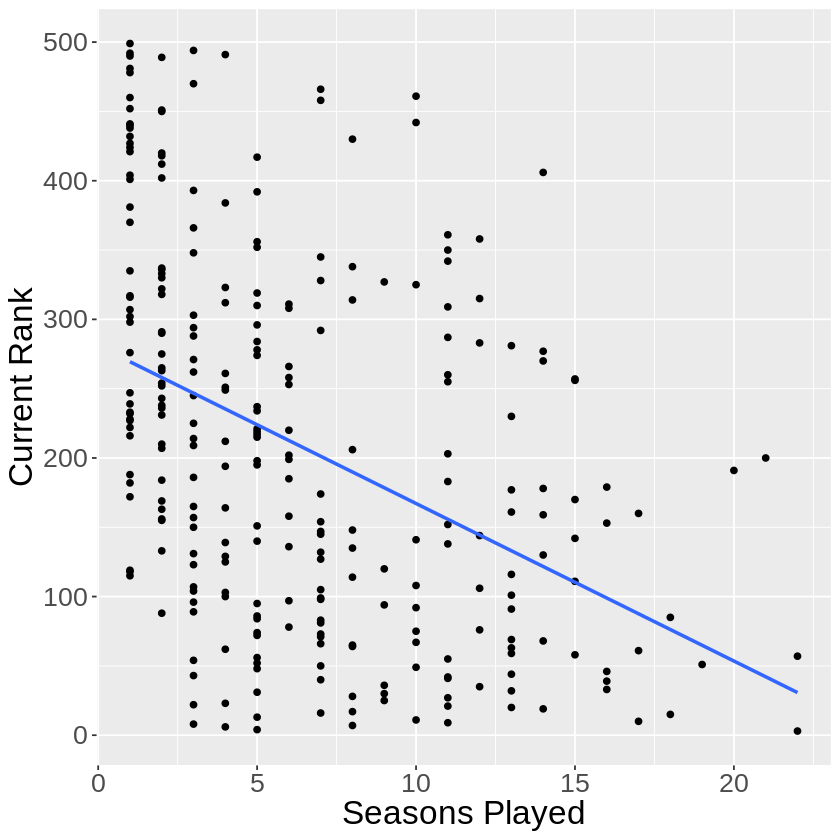

In [2]:
# split it into training and testing datasets
player_split <- initial_split(player_stats, prop = 0.75, strata = Seasons)
player_train <- training(player_split)
player_test <- testing(player_split)

# plot with best fit line
player_train_plot <- player_train |>
    ggplot(aes(x = Seasons, y = current_rank)) +
        geom_point() +
        xlab("Seasons Played") +
        ylab("Current Rank") +
        theme(text = element_text(size = 20)) +
        geom_smooth(method = "lm", se = FALSE)
player_train_plot

We start by using linear regression.

We create the model specification and recipe, and fit our simple linear regression model.

In [6]:
# linear regression
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")
lm_recipe <- recipe(Seasons ~., data = player_train)
player_lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_train)
player_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  current_rank  
      9.6770       -0.0153  


Our coefficients are (intercept)= 9.53021 and (slope) = -0.01484
This means that the equation of the line of best fit is:

**Current Rank = 9.53021 - 0.01484 * Seasons Played**

Finally, we predict on the test data set to assess how well our model does:

In [7]:
player_lm_prediction <- player_lm_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")
player_lm_prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.740473


Then, we use KNN regression to do the prediction.

First, we create a recipe for preprocessing our data.
Next we create a model specification for K-nearest neighbors regression.
Then we create a 5-fold cross-validation object, and put the recipe and model specification together in a workflow.

In [8]:
# KNN regression
player_recipe <- recipe(Seasons~., data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
player_vfold <- vfold_cv(player_train, v = 5, strata = Seasons)

Next we run cross-validation for a grid of numbers of neighbors ranging from 10 to 100. 

In [9]:
gridvals <- tibble(neighbors = seq(from = 10, to = 100, by = 10))
player_workflow <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(tuning_spec) |>
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

We take the minimum RMSPE to find the best setting for the number of neighbors:

In [10]:
# show only the row of minimum RMSPE
player_min <- player_workflow |>
    filter(mean == min(mean))
player_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
30,rmse,standard,4.345833,5,0.1089087,Preprocessor1_Model03


The smallest RMSPE occurs when  K = 30.

Next, we need to evaulate how well our model might do at predicting on unseen data. We first re-train our KNN regression model on the entire training data set, using K = 30 neighbors. 
Then we will use predict to make predictions on the test data, and use the metrics function again to compute the summary of regression quality.

In [12]:
#slice(player_test, 37)
#which(is.na(player_test), arr.ind=TRUE)

In [13]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("regression")

player_knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)

player_knn_prediction <- player_knn_fit |>
    predict(player_test) |>
    bind_cols(player_test) |>
    metrics(truth = Seasons, estimate = .pred) |>
    filter(.metric == "rmse")

player_knn_prediction 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.691381


Our KNN regression final model’s test error as assessed by RMSPE is 4.474249.

By comparision, the RMSE 4.451144 < 4.474249, therefore, we would like to choose linear regression model to do the prediction.

### Discussion

From our analysis, we found that the number of seasons a Tennis player have participated in can be used to predict their current rank using a linear regression prediction model, which produces a more accurate prediction compared to KNN regression model for our data. The two variables have a negative relationship where as the number of seasons played increases, the player’s rank decreases, indicating a higher rank. 

This finding matches our expectation that as Tennis players gains more experience through more seasons they played in, their skills will also improve as shown through their higher rank in the field. This finding is also supported by a behavioral study that discovered the main factor to predict one’s skill is the amount of practice they went through (Hambrick, Ullen, & Mosing, 2016). 

Although we cannot for sure say that experience equals expertise, our analysis shows that more experience does contribute to more advanced skills in Tennis. This most likely can apply to other fields outside of sports as well. The impacts of this finding can be used to motivate people to keep training even if they don’t see immediate positive results, whether it be at sports or anything they’re interested in. Hopefully, our discovery can also help debunk the widespread belief that you need to have a natural talent to be an athlete, which can be discouraging since talent is something that we cannot gain or control. We want to promote a healthy mindset where people are willing to take on challenges and trust in their own efforts. 

But it shouldn’t stop there, we should also consider further questions such as with the same amount of experience, does everyone's skills or rank in Tennis increased in the same way? If not, what makes them differ? And what are the other factors that can also predict a Tennis player’s rank? These questions must be answered to help create better training programs and improve the performance of Tennis players. 


### References

In [ ]:
Miner, J. W. (2016). Why 70 percent of kids quit sports by age 13. The Washington Post. https://www.washingtonpost.com/news/parenting/wp/2016/06/01/why-70-percent-of-kids-quit-sports-by-age-13/
Hambrick, D., Ullen, F., & Mosing, M. (2016). Is Innate Talent a Myth? Scientific American. https://www.smithsonianmag.com/smart-news/some-experts-think-no-matter-how-much-you-practice-if-you-dont-have-natural-talent-youll-probably-never-be-best-180952045/